# Synthetic Image Classification using Keras

## Setup environment

In [8]:
INPUT='../input'
SYNIMG=f'{INPUT}/synimg'

### When not running in the competition's Kaggle kernel

If you're running this notebook locally, you can download the competition dataset using the Kaggle CLI.

In [11]:
!kaggle competitions download -p $INPUT -c synthetic-image-classification

sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
synimg.zip: Skipping, found more recently modified local copy (use --force to force download)


In [12]:
!unzip -n -d $SYNIMG $INPUT/synimg.zip

Archive:  ../input/synimg.zip


## Take a look at the data

In [13]:
!ls $INPUT

sample_submission.csv synimg                synimg.zip


In [14]:
!ls $SYNIMG/synimg

readme.txt styles.txt test       train


## Read style list

The dataset includes a styles list, which are the possible output labels from our image classifier.

We load it here using [Pandas](https://pandas.pydata.org/), a Python library for data manipulation and analysis.

In [15]:
import pandas as pd

styles = pd.read_csv(f'{SYNIMG}/synimg/styles.txt', names=['style_name'])

In [16]:
styles

,style_name
0,Luanda
1,HongKong
2,Zurich
3,Singapore
4,Geneva
5,Beijing
6,Seoul
7,Sydney
8,Melbourne
9,Brisbane


# Check out training data

Using Pandas, we can get a quick overview of our training dataset.

In [17]:
!ls $SYNIMG/synimg/train

Beijing   Geneva    Luanda    Seoul     Sydney    data.csv
Brisbane  HongKong  Melbourne Singapore Zurich


In [18]:
import pandas as pd

train = pd.read_csv(f'{SYNIMG}/synimg/train/data.csv')

In [19]:
train.head()

,id,style_name,file,filepath
0,1000000,Luanda,train-Luanda-1000000.jpg,synimg/train/Luanda/train-Luanda-1000000.jpg
1,1000001,Luanda,train-Luanda-1000001.jpg,synimg/train/Luanda/train-Luanda-1000001.jpg
2,1000002,Luanda,train-Luanda-1000002.jpg,synimg/train/Luanda/train-Luanda-1000002.jpg
3,1000003,Luanda,train-Luanda-1000003.jpg,synimg/train/Luanda/train-Luanda-1000003.jpg
4,1000004,Luanda,train-Luanda-1000004.jpg,synimg/train/Luanda/train-Luanda-1000004.jpg


In [20]:
train.shape

(100000, 4)

In [21]:
train.groupby('style_name')[['style_name']].count()

,style_name
style_name,
Beijing,10000
Brisbane,10000
Geneva,10000
HongKong,10000
Luanda,10000
Melbourne,10000
Seoul,10000
Singapore,10000
Sydney,10000


The nice thing about notebooks is that we can even display the images.

'Luanda'

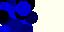

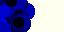

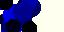

'HongKong'

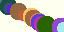

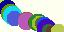

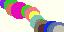

'Zurich'

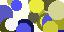

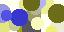

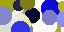

'Singapore'

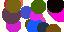

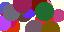

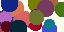

'Geneva'

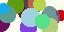

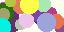

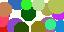

'Beijing'

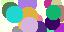

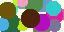

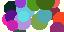

'Seoul'

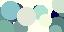

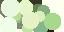

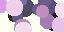

'Sydney'

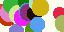

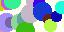

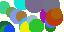

'Melbourne'

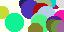

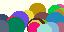

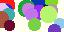

'Brisbane'

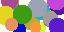

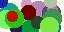

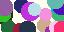

In [22]:
from IPython.display import Image

for style in styles['style_name']:
    display(style)
    for filepath in train[train['style_name'] == style]['filepath'][0:3]:
        display(Image(f'{SYNIMG}/{filepath}'))

# Check out test data

In [ ]:
!ls $SYNIMG/synimg/test

In [ ]:
import pandas as pd

test = pd.read_csv(f'{SYNIMG}/synimg/test/data_nostyle.csv')

In [ ]:
test.head()

In [ ]:
test.shape

In [ ]:
from IPython.display import Image

for filepath in test['filepath'][0:3]:
    display(Image(f'{SYNIMG}/{filepath}'))

# Get image size

In [ ]:
import keras

image = keras.preprocessing.image.load_img(f'{SYNIMG}/synimg/test/A/test-A-9000000.jpg')

In [ ]:
image.height, image.width

In [ ]:
image.getbands()

In [ ]:
image_shape = (image.height, image.width, len(image.getbands()))

In [ ]:
image_shape

# Create label encoder

In [ ]:
import sklearn.preprocessing

label_encoder = sklearn.preprocessing.LabelBinarizer()
label_encoder.fit(styles['style_name'])

In [ ]:
import numpy as np

display(label_encoder.classes_)
display(label_encoder.transform(['HongKong', 'Zurich', 'Syndey', 'Zurich']))
display(label_encoder.inverse_transform(np.array([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])))

# Data processing functions

In [ ]:
import numpy as np
import keras
import sklearn.model_selection

def load_image(filepath):
    return np.asarray(keras.preprocessing.image.load_img(f'{SYNIMG}/{filepath}')) / 255.0

def load_images(filepaths):
    return np.asarray([load_image(filepath) for filepath in filepaths])

def load_data(df):
    images = load_images(df['filepath'])
    labels = label_encoder.transform(df['style_name'])
    return sklearn.model_selection.train_test_split(images, labels, test_size=0.25)

In [ ]:
import unittest

class TestLoadImages(unittest.TestCase):
    def test_load_image(self):
        result = load_image('synimg/test/A/test-A-9000000.jpg')
        self.assertTrue(isinstance(result, np.ndarray))
        self.assertEqual(result.dtype, 'float64')
        self.assertEqual(result.shape, image_shape)
        self.assertTrue((result >= 0.0).all() and (result <= 1.0).all())
    def test_load_images(self):
        result = load_images(['synimg/test/A/test-A-9000000.jpg', 'synimg/test/B/test-B-9000001.jpg'])
        self.assertEqual(result.shape, (2, *image_shape))

class TestLoadData(unittest.TestCase):
    def test_load_data(self):
        df = pd.DataFrame({
            'style_name': [
                'Luanda',
                'Luanda',
                'Brisbane',
                'Brisbane'
            ],
            'filepath': [
                'synimg/train/Luanda/train-Luanda-1000000.jpg',
                'synimg/train/Luanda/train-Luanda-1000001.jpg',
                'synimg/train/Brisbane/train-Brisbane-1090000.jpg',
                'synimg/train/Brisbane/train-Brisbane-1090001.jpg'
            ]
        })
        X_train, X_test, y_train, y_test = load_data(df)
        self.assertEqual((X_train.shape, y_train.shape), ((3, *image_shape), (3, len(styles))))
        self.assertEqual((X_test.shape, y_test.shape), ((1, *image_shape), (1, len(styles))))

unittest.main(argv=[''], exit=False)

# Load data

In [ ]:
train_images, test_images, train_labels, test_labels = load_data(train)

# Create model

In [ ]:
from keras import layers, models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=image_shape))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(len(styles), activation='softmax'))

In [ ]:
model.summary()

# Train model

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_images, train_labels, epochs=5)

# Evaluate model

In [ ]:
test_loss, test_acc = model.evaluate(test_images, test_labels)

In [ ]:
test_acc

# Investigate performance

In [ ]:
test_predictions = model.predict(test_images)

In [ ]:
import pandas as pd

test_predictions_df = pd.DataFrame({
    'expected': label_encoder.inverse_transform(test_labels),
    'actual': label_encoder.inverse_transform(test_predictions)
})
pd.crosstab(test_predictions_df['expected'], test_predictions_df['expected'] == test_predictions_df['actual'], normalize='index')

# Run predictions

In [ ]:
real_test_images = load_images(test['filepath'])
predictions = model.predict(real_test_images)
prediction_labels = label_encoder.inverse_transform(predictions)
prediction_labels

# Submit

In [ ]:
!head $INPUT/sample_submission.csv

In [ ]:
submission = test[['id']].assign(style_name = prediction_labels)
submission.head()

In [ ]:
submission.to_csv('submission.csv', index=False)

In [ ]:
!head submission.csv

In [ ]:
#!kaggle competitions submit -c synthetic-image-classification -f submission.csv -m ''